In [1]:
%pylab inline
import math
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import fisher_exact, sem, pearsonr
from sklearn import linear_model
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
def read_score_map(weight_file, position_file):
    score_map = {}
    with open(weight_file) as f, open(position_file) as f_pos:
        while True:
            weight_info = f.readline().strip()
            position_info = f_pos.readline().strip()

            if (weight_info != "") and (position_info != ""):
                chromID, motif_start, motif_end, seq_start, seq_end, strand = position_info.split(",")
                seq_start, seq_end = int(seq_start), int(seq_end)
                weights_raw = [abs(float(wt)) for wt in weight_info.split(";")]
                weights_sum = sum(weights_raw)
                weights = [w/weights_sum for w in weights_raw]
                for idx in range(1000):
                    if (chromID, seq_start+idx) not in score_map:
                        score_map[(chromID, seq_start+idx)] = 0
                    if strand == "+":
                        if abs(weights[idx]) > abs(score_map[(chromID, seq_start+idx)]):
                            score_map[(chromID, seq_start+idx)] = weights[idx]
                    elif strand == "-":
                        if abs(weights[999-idx]) > abs(score_map[(chromID, seq_start+idx)]):
                            score_map[(chromID, seq_start+idx)] = weights[999-idx]
                    else:
                        exit("wrong strand symbol: %s" %(strand))
            elif (weight_info == "") and (position_info == ""):
                break
            else:
                exit("Files do not match:\n%s\n%s" %(weight_file, position_file))
    return score_map


data_path = "/storage/pandaman/project/Alzheimers_ResNet/storage/experiments/"
TF_name = "PU1"
position_file = os.path.join(data_path, "seqs_one_hot_extended_sliding/%s/visualization/auxiliary_info.txt" %(TF_name))
weight_file = os.path.join(data_path, "results_extended_coordconv_sliding/%s/annations_abs/scores.txt" %(TF_name))
score_map = read_score_map(weight_file, position_file)

In [3]:
allelic_imb_file = "/storage/pandaman/project/Alzheimers_ResNet/storage/allelic_imbalance/ADVariants.all_AllelicImbalance.txt"
allelic_imb_dict = {}
allelic_imb_high_folds_dict = {}
header = True
list_ttl_reads = []
for line in open(allelic_imb_file):
    if line.startswith("#"):
        continue
    else:
        if header:
            header = False
            continue
        else:
            elems = line.strip().split()
            chromID, pos = elems[0].split(":")
            chromID = "chr" + chromID
            pos = int(pos)
            ttl_reads = float(elems[3])
            ttl_ref = float(elems[4])
            ttl_alt = float(elems[5])
            pval = float(elems[6])
            allelic_imb_dict[(chromID, pos)] = (pval, ttl_reads, ttl_ref, ttl_alt)
            list_ttl_reads.append(ttl_reads)
            if ttl_reads >= 10:
                allelic_imb_high_folds_dict[(chromID, pos)] = (pval, ttl_reads, ttl_ref, ttl_alt)

print(np.mean(list_ttl_reads))
print(len(list_ttl_reads))
for i in range(10):
    print(len([elem for elem in list_ttl_reads if elem == i]))
print(len([elem for elem in list_ttl_reads if elem >= 10]))

4.876839737562798
780682
0
478854
149524
54532
24250
12450
7797
5481
4132
3235
40427


# scatter plot: score vs. log_pval

0 0.0017021253466762106 21405
1 0.0022931406808422198 4807
2 0.002573559309778399 1308
3 0.002673356079274734 574
4 0.0036079951245028756 300
5 0.0033066085419942437 231
6 0.003555930002566999 137
7 0.003600824366956253 84
8 0.0034615193298287144 85
9 0.0028107941348534116 62
10 0.003726761381776818 327
[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0] [0.00227112 0.00242258 0.00257404 0.0027255  0.00287696 0.00302842
 0.00317988 0.00333134 0.0034828  0.00363426 0.00378572]
(0.7595025646146222, 0.0066952466171754255)
0.5768441456561881


/storage/pandaman/tools_and_dependencies/anaconda/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     12.27
Date:                Thu, 24 Mar 2022   Prob (F-statistic):            0.00670
Time:                        10:24:20   Log-Likelihood:                 70.179
No. Observations:                  11   AIC:                            -136.4
Df Residuals:                       9   BIC:                            -135.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.000      8.878      0.0

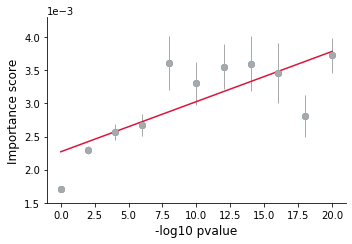

In [4]:
def plot_dist(allelic_imb_dict):
    n_bins = 10
    x_lim = 20
    gap = x_lim / n_bins
    scores_in_bins = [[] for bin_idx in range(n_bins+1)]
    
    
    list_scores = []
    list_ratio = []
    for key in allelic_imb_dict:
        if key in score_map:
            (pval, ttl_reads, ttl_ref, ttl_alt) = allelic_imb_dict[key]
            #if ttl_ref == 0 or ttl_alt == 0:
            #    continue
            if pval == 0:
                continue
            log_pval = -math.log10(pval)
            bin_idx = min(n_bins, int(round(log_pval/gap)))
            score = score_map[key]
            scores_in_bins[bin_idx].append(abs(score))

    for bin_idx in range(n_bins+1):
        print(bin_idx, np.mean(scores_in_bins[bin_idx]), len(scores_in_bins[bin_idx]))
    
    fig = plt.figure()
    fig.set_size_inches((5, 3.5))
    ax = fig.add_subplot(111)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_xlim((-1, x_lim+1))
    ax.set_ylim((0.0015, 0.0043))
    ax.set_xlabel("-log10 pvalue", size=12, fontname="Arial")
    ax.ticklabel_format(style='scientific', axis="y", scilimits=(0, 0))
    ax.set_ylabel("Importance score", size=12, fontname="Arial")
    x_vals = [_*gap for _ in range(len(scores_in_bins))]
    y_vals = [np.mean(scores_in_bins[bin_idx]) for bin_idx in range(len(scores_in_bins))]
    y_errs = [sem(scores_in_bins[bin_idx]) for bin_idx in range(len(scores_in_bins))]
    
    regr = linear_model.LinearRegression()
    x_mat = [[val] for val in x_vals]
    regr.fit(x_mat, y_vals)
    y_pred = regr.predict(x_mat)
    print(x_vals, y_pred)
    print(pearsonr(x_vals, y_vals))
    ax.plot(x_vals, y_pred, color="crimson")
    
    print(regr.score(x_mat, y_vals))
    print(sm.OLS(y_vals, sm.add_constant(x_mat)).fit().summary())
    
    ax.scatter(x_vals, y_vals, marker="o")
    ax.errorbar(x_vals, y_vals, yerr=y_errs, marker="o", linewidth=0, elinewidth=1, color="darkgrey")
    
    plt.tight_layout()
    #fig.savefig("./score_vs_allelic_imbalance_pval.pdf")

plot_dist(allelic_imb_dict)